# Importare le Librerie

In [1]:
import pandas as pd
import numpy as np
import glob
from scipy import stats
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing #aggiunto per normalizzazioni
import matplotlib.pyplot as plt

# Analisi consumo di energia elettrica e temperatura esterna

Dal data set indicato nel link sotto, vogliamo verificare e prevedere con una Regressione Lineare quale sia la relazione tra consumo di energia elettrica e temperatura esterna in un edificio pubblico commerciale.

Origine dati: open datasets su consumo di energia elettrica e temperatura esterna per 11 edifici commerciali in USA
https://openei.org/datasets/dataset/consumption-outdoor-air-temperature-11-commercial-buildings.
Prendiamo il primo edificio, si trova in Fremont California USA.

#### Carichiamo i dati usando direttamente la libreria Pandas (pd). Questa libreria ci permette di caricare i dati in matrici (array numpy) in forma tabellare facilmente maneggiabile.

In [3]:
path_cartella="../dati_LRegr/"

filename = path_cartella+'building1retail.csv'
df = pd.read_csv(filename, index_col=[0], date_parser=lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M"))
#utlizzando il parametro chunksize=n è possibile selezionare casualmente n righe dal csv
df.head()

,OAT (F),Power (kW)
Timestamp,,
2010-01-01 01:15:00,51,165.1
2010-01-01 01:30:00,51,151.6
2010-01-01 01:45:00,51,146.9
2010-01-01 02:00:00,51,153.7
2010-01-01 02:15:00,51,153.8


In [4]:
#load several csv into one dataframe

filenames = glob.glob(path_cartella+'building*retail.csv')
df_w = pd.DataFrame()

for filename in filenames:
    print(filename)
    df = pd.read_csv(filename, index_col=[0], date_parser=lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M"))
    #print(df.info())
    
    df_w = df_w.append(df)
    del(df)
df = df_w
del(df_w)

df.info()
df.head()
df.tail()

../dati_LRegr\building1retail.csv
../dati_LRegr\building2retail.csv
../dati_LRegr\building3retail.csv
../dati_LRegr\building4retail.csv
../dati_LRegr\building5retail.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174700 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 2 columns):
OAT (F)       174700 non-null int64
Power (kW)    174700 non-null float64
dtypes: float64(1), int64(1)
memory usage: 4.0 MB


,OAT (F),Power (kW)
Timestamp,,
2010-12-30 23:00:00,67,333.7
2010-12-30 23:15:00,68,221.0
2010-12-30 23:30:00,68,235.7
2010-12-30 23:45:00,68,227.2
2010-12-31 00:00:00,68,234.5


OAT = outside air temperature, in farheneit ;  Power = energia elettrica consumata in kW

In [4]:
#per comodità rinominiamo le colonne
df.rename(columns={"OAT (F)": "temp", "Power (kW)": "elect"}, inplace=True)

In [5]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174700 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 2 columns):
temp     174700 non-null int64
elect    174700 non-null float64
dtypes: float64(1), int64(1)
memory usage: 4.0 MB
(174700, 2)


### Ottimizzare l'occupazione della memoria

In [6]:
#controllo valori minimi e massimi
print(df.elect.max())
print(df.elect.min())

print(df.temp.max())
print(df.temp.min())

558.1
0.0
102
0


In [7]:
#con questi valori è sufficiente usare int8 per temp fino a 127 e float32 per elect fino a ? ()
df.temp = df.temp.astype("int8")
df.elect = df.elect.astype("float32")

In [8]:
#viene occupata quasi metà memoria con questi tipi
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174700 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 2 columns):
temp     174700 non-null int8
elect    174700 non-null float32
dtypes: float32(1), int8(1)
memory usage: 2.2 MB


In [9]:
#posso fare delle statistiche veloci sull'insieme del dataframe con .describe()
df.describe()
#questi sono valori relativi alla singola riga che rappresenta 15 minuti di consumo

,temp,elect
count,174700.000000,174700.000000
mean,61.027934,279.815155
std,16.250278,89.329483
min,0.000000,0.000000
25%,52.000000,207.300003
50%,61.000000,283.100006
75%,73.000000,340.125008
max,102.000000,558.099976


##### Per avere un analisi equivalente per il consumo giornaliero dobbiamo raggruppare i dati per intervallo giornaliero, per noi "d"

In [10]:
df["elect"].resample("d").sum().describe().round(1) #.min()

count       365.0
mean     133929.7
std       15980.7
min         934.6
25%      123968.9
50%      130777.4
75%      147347.9
max      167933.8
Name: elect, dtype: float64

# Esplorazione e visualizzazione dati

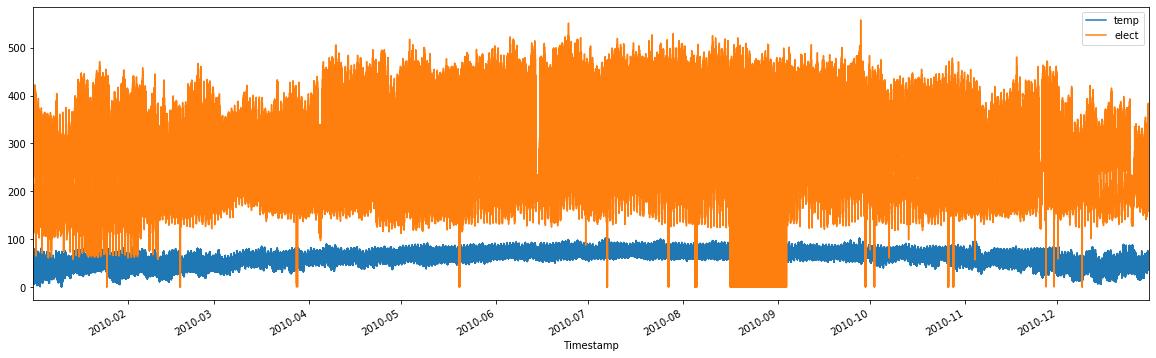

In [11]:
df.plot(figsize=(20,6))

Nel grafico vediamo che ci sono dei picchi per valori bassi che si allontanano molto dall'andamento della curva per il resto dei dati.

### Controllo valori mancanti o nulli

In [12]:
df.isnull().values.any()

False

Non cisono valori mancanti o nulli. 
Se ci fossero potrei usare il metodo df.dropna() per elimimare le righe con valori nulli, questa funzione ha diversi parametri naturalmente

### Distribuzione dei dati

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E3C0418C8>,
      dtype=object)

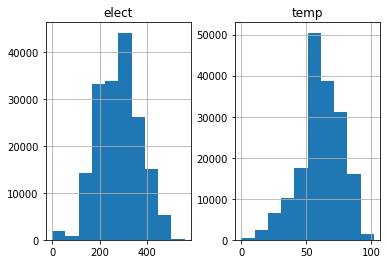

In [13]:
df.hist()

.hist() crea un istogramma per colonna e ci da una rappresentazione grafica della distribuzione dei dati.

### Rimozione degli outliers

In [14]:
# in genere 3 deviazioni standard risulta essere il criterio migliore per la rimozione degli outliers, 
# tuttavia dipende dalla quantità di dati usati, nel caso di dati di piccole dimensioni anche 2 deviazioni standard può essere ragionevole
std_dev = 3
df_new = df[(np.abs(stats.zscore(df)) < float(std_dev)).all(axis=1)]
#Returns True unless there at least one element within a series or along a Dataframe axis that is False or equivalent (e.g. zero or empty).
#1 / ‘columns’ : reduce the columns, return a Series whose index is the original index.

In [15]:
print(df.info())
print(df_new.info())
print("righe_rimosse", df.shape[0]-df_new.shape[0])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174700 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 2 columns):
temp     174700 non-null int8
elect    174700 non-null float32
dtypes: float32(1), int8(1)
memory usage: 2.2 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172034 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 2 columns):
temp     172034 non-null int8
elect    172034 non-null float32
dtypes: float32(1), int8(1)
memory usage: 2.1 MB
None
righe_rimosse 2666


Con questo comando abbiamo rimosso tutte le righe (circa 2700) contenenti outliers oltre 3 deviazioni standard.

# Visualizzazione dati "puliti"

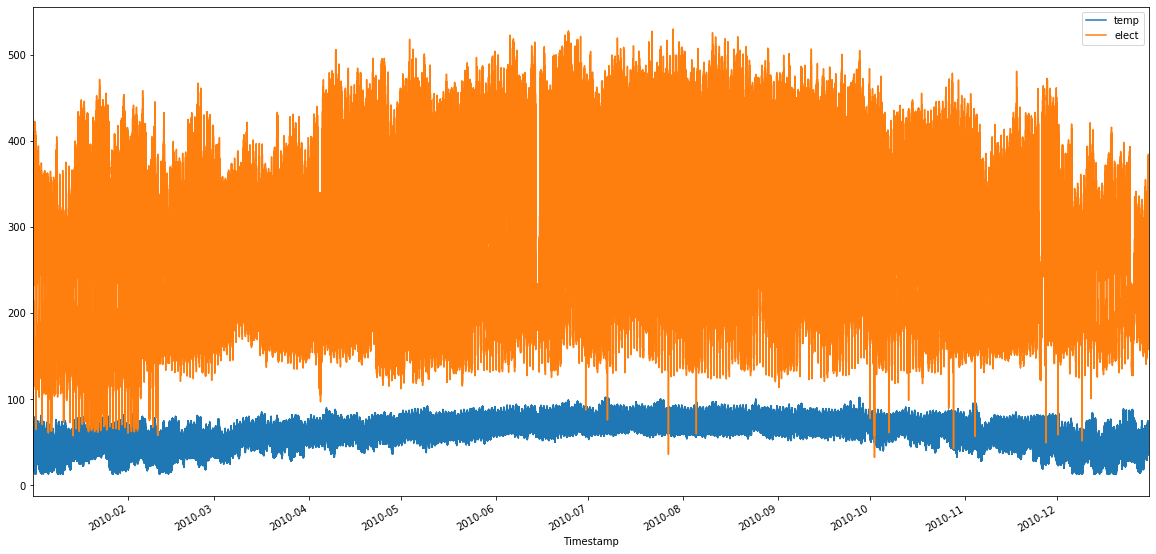

In [16]:
df_new.plot(figsize=(20,10))

la rappresentazione grafica ci fa vedere che ci sono ancoa numerosi outliers, forse occorre rimuovere gli outliers fino a 2 deviazioni standard o ripetere il procedimento con 3 stdev su df_new

In [17]:
std_dev = 2
df_new = df[(np.abs(stats.zscore(df)) < float(std_dev)).all(axis=1)]

print(df.info())
print(df_new.info())
print("righe_rimosse", df.shape[0]-df_new.shape[0])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174700 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 2 columns):
temp     174700 non-null int8
elect    174700 non-null float32
dtypes: float32(1), int8(1)
memory usage: 2.2 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161270 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 2 columns):
temp     161270 non-null int8
elect    161270 non-null float32
dtypes: float32(1), int8(1)
memory usage: 2.0 MB
None
righe_rimosse 13430


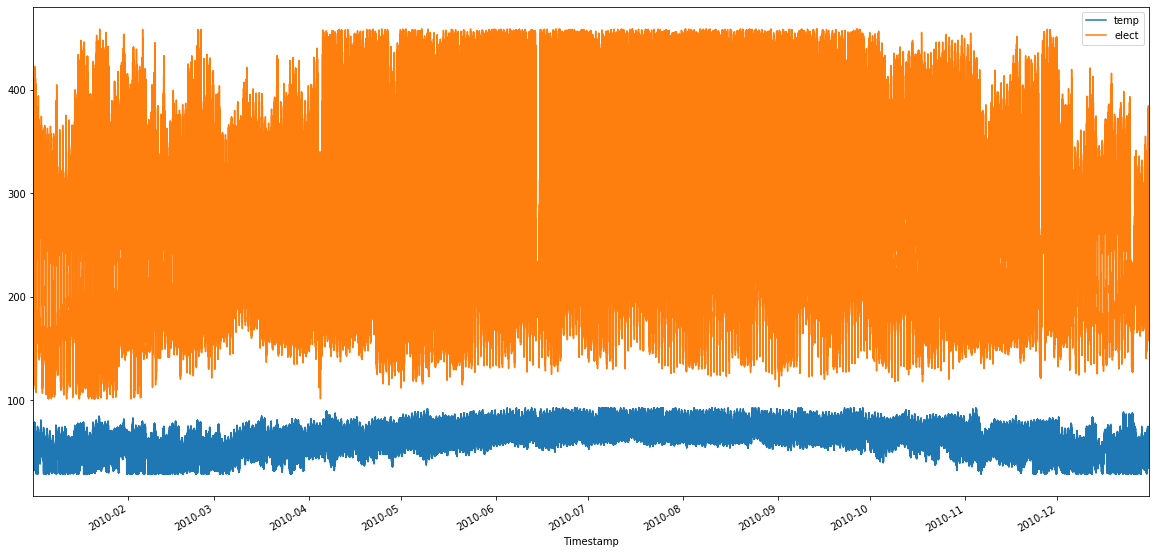

In [18]:
df_new.plot(figsize=(20,10))

Il grafico ci mostra che con 2 deviazioni standard come criterio di di rimozione degli outliers otteniamo dei dati più omogenei

# Visualizzazione dati sul mese di Gennaio

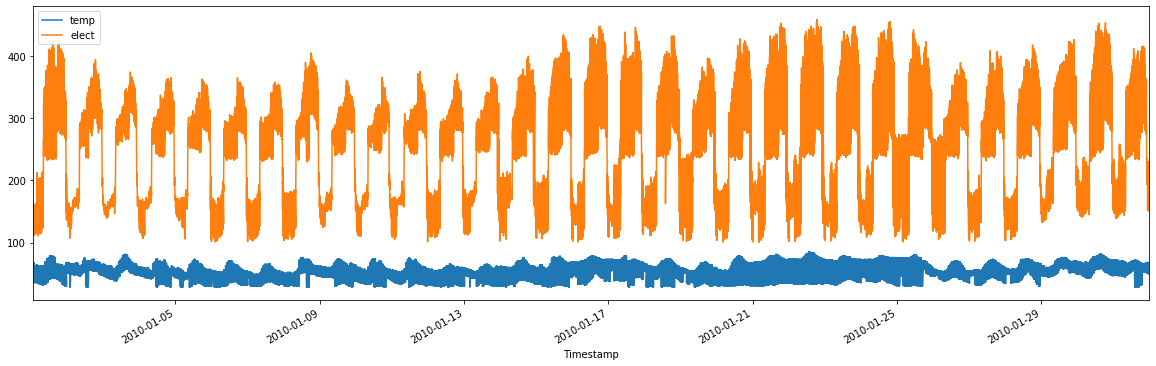

In [19]:
#uso l'indice delle righe per selezionare un mese
df_new["2010-1-01":"2010-1-31"].plot(figsize=(20,6))

Riscontriamo una certa regolarità, in particolare nel consumo di energia, probabilmente legata alle ore del giorno, questa dinamica dei dati ci servirà dopo nell'analisi della regressione. Forse anche il periodo dell'anno, il mese, potrebbe influire sul consumo di energia.

In [20]:
#from noew on our df is df_new, the cleaned df
df=df_new

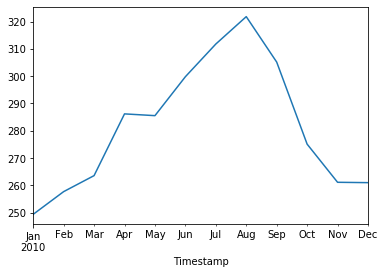

In [21]:
# resample dell'indice per mese con calcolo della media dei valori
df["elect"].resample("m").mean().plot()

Vediamo un maggiore consumo nei mesi estivi, dovuto all'uso di aria condizionata probabilmente

### Visualizzazione di un giorno scelto casualmente

#### temperatura esterna dell'aria

Thursday


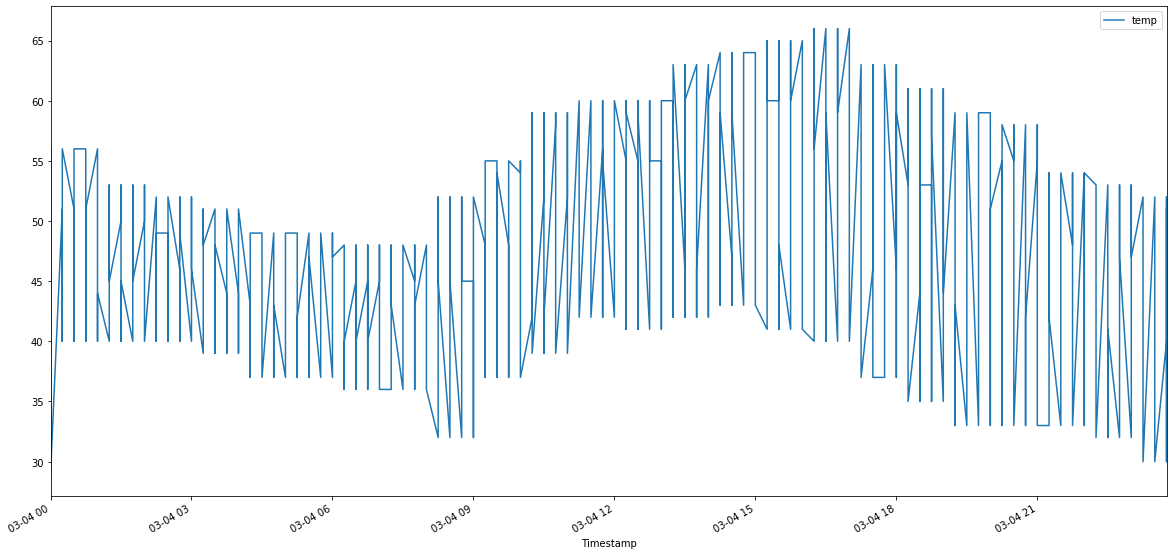

In [22]:
df.loc['2010-03-04', ["temp"]].plot(figsize=(20,10))

# Prints the day
print(df.loc['2010-03-04'].index.day_name()[0])

Notiamo anche che i dati sono nel fuso orario locale cioè PST, poiché l'edificio si trova in California

#### Consumo di energia nello stesso giorno

Thursday


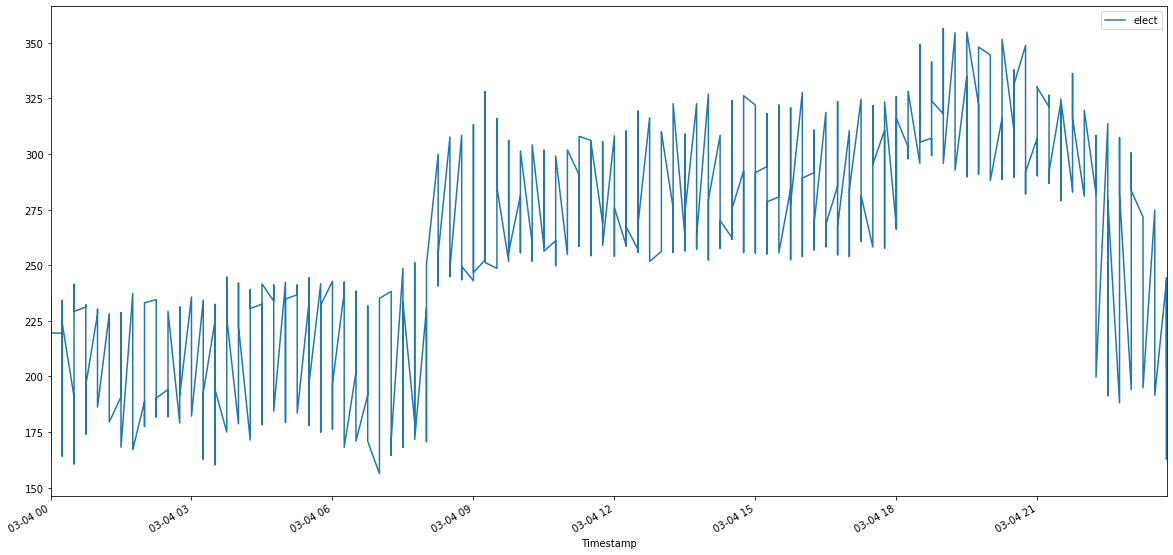

In [23]:
df.loc['2010-03-04', ["elect"]].plot(figsize=(20,10))
print(df.loc['2010-03-04'].index.day_name()[0])

I due grafici mostrano che il consumo giornaliero di eletricità segue solo in parte l'andamento della temperatura, occorrerà quindi introdurre l'ora del giorno come come variabile per mgliorare la nostra previsione

## Ispezione grafica della relazione tra le variabili temp ed elect

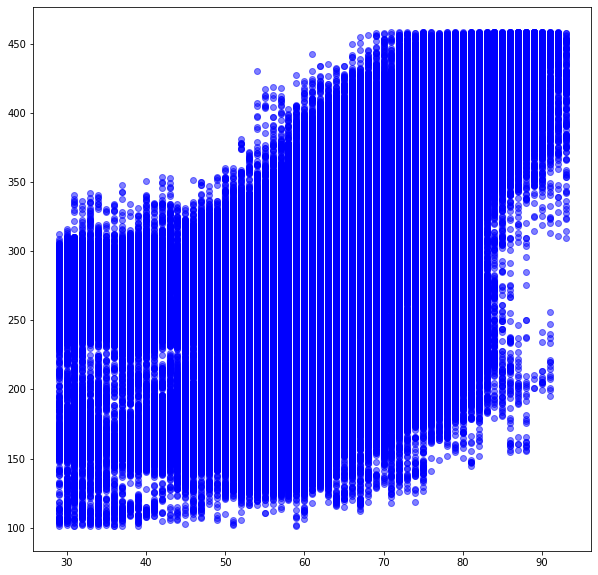

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(x=df["temp"], y=df["elect"], color="blue", alpha=0.5)

Il grafico ci mostra una distribuzione che non sembra essere del tutto lineare, questo era prevedibile visto il ruolo giocato dal tempo (ora, mese, ecc) nell'andamento dei cosnumi.

## Preprocessing

Normalizzazione dei dati

In [25]:
df_new = df_new[["temp","elect"]]
df = df_new

In [26]:
%%time
# %%time ci permete di stampare il tempo di esecuzione della cella

for column in df.columns:
    min_c=df[column].min()
    max_c=df[column].max()
    df.loc[:, column+"norm"]=(df[column]-min_c)/(max_c-min_c)

Wall time: 50.1 ms


In [27]:
#verifichiamo il risultato con describe
df.describe()

,temp,elect,tempnorm,electnorm
count,161270.000000,161270.000000,161270.000000,161270.000000
mean,62.078713,281.961945,0.516855,0.506066
std,13.647797,80.360748,0.213247,0.224979
min,29.000000,101.199997,0.000000,0.000000
25%,54.000000,212.600006,0.390625,0.311870
50%,62.000000,285.100006,0.515625,0.514838
75%,72.000000,339.500000,0.671875,0.667133
max,93.000000,458.399994,1.000000,1.000000


Questa normalizzazione tra 0 e 1 si può fare in diversi modi, ma questo è quello più veloce ed efficiente. Oltre al metodo usato con calcolo vettoriale su matrice si può usare la funzione apply o il metodo fornito nella sezione preprocessing di sklearn, entrambi riportati nelle celle sottostanti commentate.

In [ ]:
#from sklearn import preprocessing
"""%%time
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_df = pd.DataFrame(x_scaled, columns=df.columns)
scaled_df.describe()"""

In [ ]:
"""%%time
column="temp"
min_c=df[column].min()
max_c=df[column].max()
df.loc[:,column+"norm"] = df[column].apply(lambda x: (x - min_c) / (max_c - min_c))"""

# Fit dei dati per la Regressione Lineare

Proviamo ad applicare una regressione lineare per la sola variabile indipendente temp

In [42]:
# funziona ma è ridondante
# X = pd.DataFrame(df['OAT (F)']) 
# y = pd.DataFrame(df['Power (kW)'])

In [28]:
# modo corretto di selezionare i sottoinsiemi di dataframe
X = df.loc[:,["temp"]]
y = df.loc[:,["elect"]]

In [29]:
%%time 
regr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train the model using the training sets
model = regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(y_test, y_pred))

Coefficient of determination: 0.32
Wall time: 49.9 ms


#### Grafico dell'output del modello

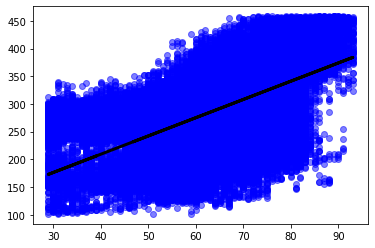

In [30]:
# Plot outputs
plt.scatter(X_test, y_test, color='blue', alpha=0.5)
plt.plot(X_test, y_pred, color='black', linewidth=3)

plt.show()

I risultati dell'applicazione della regressione per la temperatura come singola variabile indipendente non sono così buoni (coefficiente inferiore a 4). Proababilmente perché non viene preso in considerazione l'andamento periodico del consumo di energia come evidenziato dai grafici. Proviamo quindi ad aggiungere l'ora del giorno come variabile e a rifare il modello.

### Preprocessing 2

Aggiungiamo l'ora del giorno, il mese e il giorno della settimana come variabili.

In [31]:
df["ora"] = df.index.hour
df["mese"] = df.index.month
df["giornosettimana"] = df.index.dayofweek
print(df.head())
print(df.info())

                     temp       elect  tempnorm  electnorm  ora  mese  \
Timestamp                                                               
2010-01-01 01:15:00    51  165.100006   0.34375   0.178891    1     1   
2010-01-01 01:30:00    51  151.600006   0.34375   0.141097    1     1   
2010-01-01 01:45:00    51  146.899994   0.34375   0.127940    1     1   
2010-01-01 02:00:00    51  153.699997   0.34375   0.146976    2     1   
2010-01-01 02:15:00    51  153.800003   0.34375   0.147256    2     1   

                     giornosettimana  
Timestamp                             
2010-01-01 01:15:00                4  
2010-01-01 01:30:00                4  
2010-01-01 01:45:00                4  
2010-01-01 02:00:00                4  
2010-01-01 02:15:00                4  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161270 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 7 columns):
temp               161270 non-null int8
elect              161270 non-n

Scatters con le nuove variabili (aggiunte come terza variabile colore)
In questo caso occorrerebbe anche randomizzare le righe per evitare che la disposizione dei dati sia tale da creare un bias nella visualizzazione.

(161270, 7)


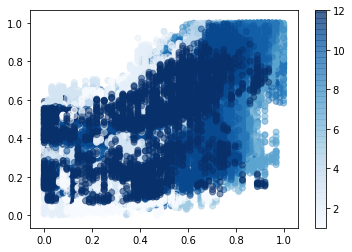

In [32]:
df.sample(frac=1, replace=False, random_state=1)
print(df.shape)
plt.scatter(df["tempnorm"], df.electnorm, c=df["mese"], cmap="Blues", alpha=0.5)
plt.colorbar()
plt.show()

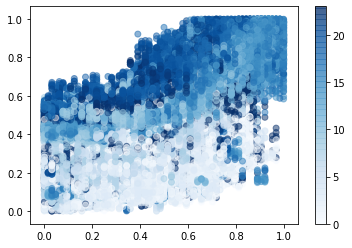

In [33]:
plt.scatter(df["tempnorm"], df.electnorm, c=df["ora"], cmap="Blues", alpha=0.5)
plt.colorbar()
plt.show()

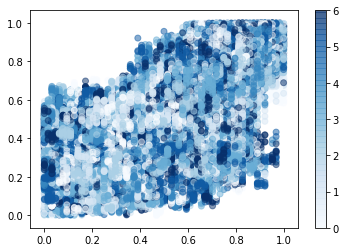

In [34]:
plt.scatter(df["tempnorm"], df.electnorm, c=df["giornosettimana"], cmap="Blues", alpha=0.5)
plt.colorbar()
plt.show()

Ora e mese sembrano distribuirsi in modo più interessante come prevedibile anche dai grafici visti in precedenza. Mentre il giorno della settimana non sembra presentare regolarità visibili.

In [57]:
#se volessimo eliminare queste colonne in seguito usiamo df.drop()
#df.drop(["ora","mese","giornosettimana"], axis=1, inplace=True)

## Refactor della sezione di modelling LR

In [35]:
#prima di andare avanti scriviamo una funzione per la parte di modelling per non riscrivere tutto ogni volta
def apply_LR(df, columns=["tempnorm","ora"], target=["elect"]):
    
    X = df.loc[:,columns]
    y = df.loc[:,target]
    
    regr = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #Random state ensures that the splits that you generate are reproducible. 

    # Train the model using the training sets
    model = regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: ', metrics.r2_score(y_test, y_pred))
    
    return X_train, X_test, y_train, y_test, y_pred, regr

### Applicazione Regressione Lineare Multipla

In [36]:
X_train, X_test, y_train, y_test, y_pred, regr = apply_LR(df, columns=["tempnorm","ora","mese","giornosettimana"], target=["electnorm"])

Coefficient of determination:  0.5734891599619504


Aggiungendo 3 variabili temporali bbiamo avuto un miglioramento significativo, ma forse è possibile fare di più arricchendo ulteriormente i dati.

### Preprocessing 3 - affinare i dati per il modello

#### Proiettare una variabile con n valori su n variabili binarie

Definiamo una funzione da applicare le volte che vogliamo, usando il metodo get_dummies di pandas per trasformare una variabile categorica o discreta in n variabili dummy indicator binarie. Per esempio ora del giorno diventa ora_1, ora_2, ecc.

In [37]:
def binary_dummy_conversion(df, var):

    # drop_first = True rimuove la correlazione tra l'ultima colonna e le precedenti eliminando la prima colonna
    add_var = pd.get_dummies(df[var], prefix=var, drop_first=True)

    # qui abbiamo un esempio molto semplice di join su l'indice
    #df = df.join(add_var)
    df = df.assign(**add_var)
    
    # Drop della colonna di partenza che abbiamo espanso
    df.drop(columns=[var], inplace=True)

    return df

In [38]:
df = binary_dummy_conversion(df, "ora")
print(df.shape)

(161270, 29)


In [39]:
#df.drop(columns=["ora"], inplace=True)
df.head()

,temp,elect,tempnorm,electnorm,mese,giornosettimana,ora_1,ora_2,ora_3,ora_4,...,ora_14,ora_15,ora_16,ora_17,ora_18,ora_19,ora_20,ora_21,ora_22,ora_23
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:15:00,51,165.100006,0.34375,0.178891,1,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:30:00,51,151.600006,0.34375,0.141097,1,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:45:00,51,146.899994,0.34375,0.127940,1,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,51,153.699997,0.34375,0.146976,1,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:15:00,51,153.800003,0.34375,0.147256,1,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#selezioniamo le colonne che ci interessano mettendo da parte il target (elect e electnorm) e temp non normalizzata
columns=df.drop(["elect","electnorm","temp"], axis=1, inplace=False).columns.to_list() 
#columns
#to_list() può essere tolist() per versioni meno recenti di pandas

In [41]:
df.head()

,temp,elect,tempnorm,electnorm,mese,giornosettimana,ora_1,ora_2,ora_3,ora_4,...,ora_14,ora_15,ora_16,ora_17,ora_18,ora_19,ora_20,ora_21,ora_22,ora_23
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:15:00,51,165.100006,0.34375,0.178891,1,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:30:00,51,151.600006,0.34375,0.141097,1,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:45:00,51,146.899994,0.34375,0.127940,1,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,51,153.699997,0.34375,0.146976,1,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:15:00,51,153.800003,0.34375,0.147256,1,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X_train, X_test, y_train, y_test, y_pred, regr = apply_LR(df, columns=columns, target=["electnorm"])

Coefficient of determination:  0.730216859644307


Con l'espansione della colonna delle ore abbiamo ottenuto un migioramento significativo e abbiamo adesso un coefficiente soddisfacente. 
Proviamo a fare la stessa cosa per mese e giorno della settimana.

In [43]:
df = binary_dummy_conversion(df, "giornosettimana")
columns=df.drop(["elect","electnorm","temp"], axis=1, inplace=False).columns.to_list()
X_train, X_test, y_train, y_test, y_pred, regr = apply_LR(df, columns=columns, target=["electnorm"])

Coefficient of determination:  0.7308854546592527


In [44]:
#il giorno della settimana non ci da nessun miglioramento significativo, procediamo quindi alla rimozione delle variabili dummy relative
tobe_dropped=["giornosettimana_1","giornosettimana_2","giornosettimana_3","giornosettimana_4","giornosettimana_5","giornosettimana_6"]
df.drop(tobe_dropped, axis=1, inplace=True)

In [38]:
"""df.tempnorm = df.tempnorm.astype("float32")
df.electnorm = df.electnorm.astype("float32")
df.mese = df.mese.astype("int8")"""

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161270 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 28 columns):
temp         161270 non-null int8
elect        161270 non-null float32
tempnorm     161270 non-null float64
electnorm    161270 non-null float64
mese         161270 non-null int64
ora_1        161270 non-null uint8
ora_2        161270 non-null uint8
ora_3        161270 non-null uint8
ora_4        161270 non-null uint8
ora_5        161270 non-null uint8
ora_6        161270 non-null uint8
ora_7        161270 non-null uint8
ora_8        161270 non-null uint8
ora_9        161270 non-null uint8
ora_10       161270 non-null uint8
ora_11       161270 non-null uint8
ora_12       161270 non-null uint8
ora_13       161270 non-null uint8
ora_14       161270 non-null uint8
ora_15       161270 non-null uint8
ora_16       161270 non-null uint8
ora_17       161270 non-null uint8
ora_18       161270 non-null uint8
ora_19       161270 non-null uint8
ora_20    

si noti che aumentando le variabili abbiamo aumentato la memoria occuapta dei dati di quasi 5 volte

In [46]:
#proviamo con il mese
df = binary_dummy_conversion(df, "mese")

In [48]:
df.head()

,temp,elect,tempnorm,electnorm,ora_1,ora_2,ora_3,ora_4,ora_5,ora_6,...,mese_3,mese_4,mese_5,mese_6,mese_7,mese_8,mese_9,mese_10,mese_11,mese_12
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:15:00,51,165.100006,0.34375,0.178891,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:30:00,51,151.600006,0.34375,0.141097,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:45:00,51,146.899994,0.34375,0.127940,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,51,153.699997,0.34375,0.146976,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:15:00,51,153.800003,0.34375,0.147256,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df.shape

(161270, 38)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161270 entries, 2010-01-01 01:15:00 to 2010-12-31 00:00:00
Data columns (total 38 columns):
temp         161270 non-null int8
elect        161270 non-null float32
tempnorm     161270 non-null float64
electnorm    161270 non-null float64
ora_1        161270 non-null uint8
ora_2        161270 non-null uint8
ora_3        161270 non-null uint8
ora_4        161270 non-null uint8
ora_5        161270 non-null uint8
ora_6        161270 non-null uint8
ora_7        161270 non-null uint8
ora_8        161270 non-null uint8
ora_9        161270 non-null uint8
ora_10       161270 non-null uint8
ora_11       161270 non-null uint8
ora_12       161270 non-null uint8
ora_13       161270 non-null uint8
ora_14       161270 non-null uint8
ora_15       161270 non-null uint8
ora_16       161270 non-null uint8
ora_17       161270 non-null uint8
ora_18       161270 non-null uint8
ora_19       161270 non-null uint8
ora_20       161270 non-null uint8
ora_21    

In [51]:
droplist=["elect","electnorm","temp"]
columns=df.drop(droplist, axis=1, inplace=False).columns.to_list() 
X_train, X_test, y_train, y_test, y_pred, regr = apply_LR(df, columns=columns, target=["electnorm"])

Coefficient of determination:  0.7402201597891584


Espandendo il mese abbiamo raggiunto un coefficiente dell' 74%, un buon risultato per una regressione lineare su questi dati. 

NB: Le trasformazioni applicate in questo esempio sono solo illustrative di techniche possibili utilizzabili in python, pandas e sklearn, non sono necessariamente le uniche o le migliori da un punto di vista statistico.